In [1]:
# Datenzugriff
from models import *

# Utils
from src.utils.new_filter import *
import src.utils.presenter as show
from src.utils.analize import check_constrains as check

# Solver Model
from src.models.cp import lateness_rescheduling as cp_late_reschedule

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Extern
import pandas as pd

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
# Harte Abbruchbedingung für die Scheduler
max_time = 60*30     # 30 min

init_version = "CP_Lateness_v00"
this_version = f"{init_version}_devpen"

# Simulation
simulation = ProductionSimulation(sigma = 0.15)

## I. Laden des fertigen Job-Shop Scheduling Problems und der dazugehörigen Produktionsauftragsinformationen
- aktuelle Version!

In [3]:
# Jobs
df_jobs_times = Job.get_dataframe(version=init_version)
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,Deadline,Status,Version
0,J25-0000,8,79,1440,3660,open,CP_Lateness_v00
1,J25-0001,6,129,1440,2338,nothing to schedule,CP_Lateness_v00
2,J25-0002,0,198,1440,3744,open,CP_Lateness_v00
3,J25-0003,2,243,1440,3379,open,CP_Lateness_v00
4,J25-0004,3,287,1440,4856,open,CP_Lateness_v00
5,J25-0005,1,498,1440,3106,open,CP_Lateness_v00
...,...,...,...,...,...,...,...
1187,J25-1187,5,85934,86400,88481,open,CP_Lateness_v00
1188,J25-1188,8,85975,86400,88866,open,CP_Lateness_v00
1189,J25-1189,1,86001,86400,88375,open,CP_Lateness_v00


In [4]:
# Routings
df_routings = RoutingOperation.get_dataframe()
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
5,0,5,M05,11
...,...,...,...,...
94,9,4,M08,64
95,9,5,M09,76
96,9,6,M05,47


In [5]:
def get_jssp_for_jobs(df_jobs_times, df_routings):
    """
    Erstellt ein JSSP-kompatibles DataFrame durch Verknüpfung von Job-Zeitdaten mit Routings.

    Parameter:
    - df_jobs_times: DataFrame mit mindestens den Spalten 'Job' und 'Routing_ID'.
    - df_routings: DataFrame mit Spalte 'Routing_ID' und den zugehörigen Operationsdaten.

    Rückgabe:
    - df_jssp: DataFrame mit allen für das JSSP notwendigen Informationen, inklusive 'Job' und den Operationen.
    """
    # 1. Relevante Spalten extrahieren
    df_job_ids = df_jobs_times[['Job', 'Routing_ID']].copy()

    # 2. Merge mit df_routings über Routing_ID
    df_jssp = df_job_ids.merge(df_routings, on='Routing_ID')

    return df_jssp

In [6]:
df_jssp = get_jssp_for_jobs(df_jobs_times, df_routings)
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
11924,J25-1192,3,4,M06,9
11925,J25-1192,3,5,M08,52
11926,J25-1192,3,6,M07,85


### Kopie

In [7]:
Job.clone_jobs(referenced_version=init_version, new_version=this_version)
JobOperation.clone_operations(referenced_version=init_version, new_version=this_version)
Schedule.clone_schedules(referenced_version=init_version, new_version=this_version)

✅ 1193 Jobs von Version 'CP_Lateness_v00' nach Version 'CP_Lateness_v00_devpen' kopiert.
✅ 11930 JobOperation-Einträge von Version 'CP_Lateness_v00' nach Version 'CP_Lateness_v00_devpen' kopiert.
✅ 1 Schedule-Einträge von Version 'CP_Lateness_v00' nach 'CP_Lateness_v00_devpen' kopiert.


## Tag 1
- Am Tag 0 kommen die ersten Produktionsaufträge an, somit kann noch nichts geplant werden
- Am Tag 1 findet die initiale Planung statt

In [8]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [9]:
df_schedule = Schedule.get_schedule_as_dataframe(date=day_numb, version=this_version)
df_schedule

,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0005,1,498,1440,3106,0,M00,1440,43,1483
1,J25-0007,5,925,1440,2929,0,M02,1440,84,1524
2,J25-0013,3,1192,1440,2567,0,M01,1440,81,1521
3,J25-0011,1,1030,1440,3210,0,M00,1483,43,1526
4,J25-0001,6,129,1440,2338,0,M01,1521,46,1567
5,J25-0013,3,1192,1440,2567,1,M02,1524,95,1619
...,...,...,...,...,...,...,...,...,...,...
154,J25-0006,9,790,1440,3539,9,M07,3494,45,3539
155,J25-0009,7,1004,1440,3578,9,M03,3499,79,3578
156,J25-0000,8,79,1440,3660,9,M08,3586,74,3660


In [10]:
df_execution = JobOperation.get_dataframe(version=this_version, status="finished")
df_execution

,Job,Routing_ID,Machine,Operation,Start,End,Processing Time,Version,Operation Status
0,J25-0000,8,M00,0,1557.0,1646.0,89.0,CP_Lateness_v00_devpen,finished
1,J25-0000,8,M01,1,1852.0,1924.0,72.0,CP_Lateness_v00_devpen,finished
2,J25-0000,8,M03,2,2257.0,2318.0,61.0,CP_Lateness_v00_devpen,finished
3,J25-0000,8,M05,3,2467.0,2510.0,43.0,CP_Lateness_v00_devpen,finished
4,J25-0000,8,M02,4,2510.0,2584.0,74.0,CP_Lateness_v00_devpen,finished
5,J25-0000,8,M09,5,2654.0,2665.0,11.0,CP_Lateness_v00_devpen,finished
...,...,...,...,...,...,...,...,...,...
136,J25-0015,5,M03,3,1812.0,1899.0,87.0,CP_Lateness_v00_devpen,finished
137,J25-0015,5,M08,4,1988.0,2041.0,53.0,CP_Lateness_v00_devpen,finished
138,J25-0015,5,M09,5,2070.0,2151.0,81.0,CP_Lateness_v00_devpen,finished


In [11]:
df_active = JobOperation.get_dataframe(version=this_version, status="active")
df_active

,Job,Routing_ID,Machine,Operation,Start,End,Processing Time,Version,Operation Status
0,J25-0000,8,M04,8,2856.0,2882.0,26.0,CP_Lateness_v00_devpen,active


In [12]:
simulation.set_active_operations_from_df(df_active)

## Tag 2 - 3

Tag 02: [2880, 4320)

Solver-Status         : OPTIMAL
Objective Value       : 1890.00
Best Objective Bound  : 1890.00
Laufzeit              : 0.45 Sekunden
Deviation terms       : 17
✅ Schedule hinzugefügt (Version=CP_Lateness_v00_devpen, Date=2)


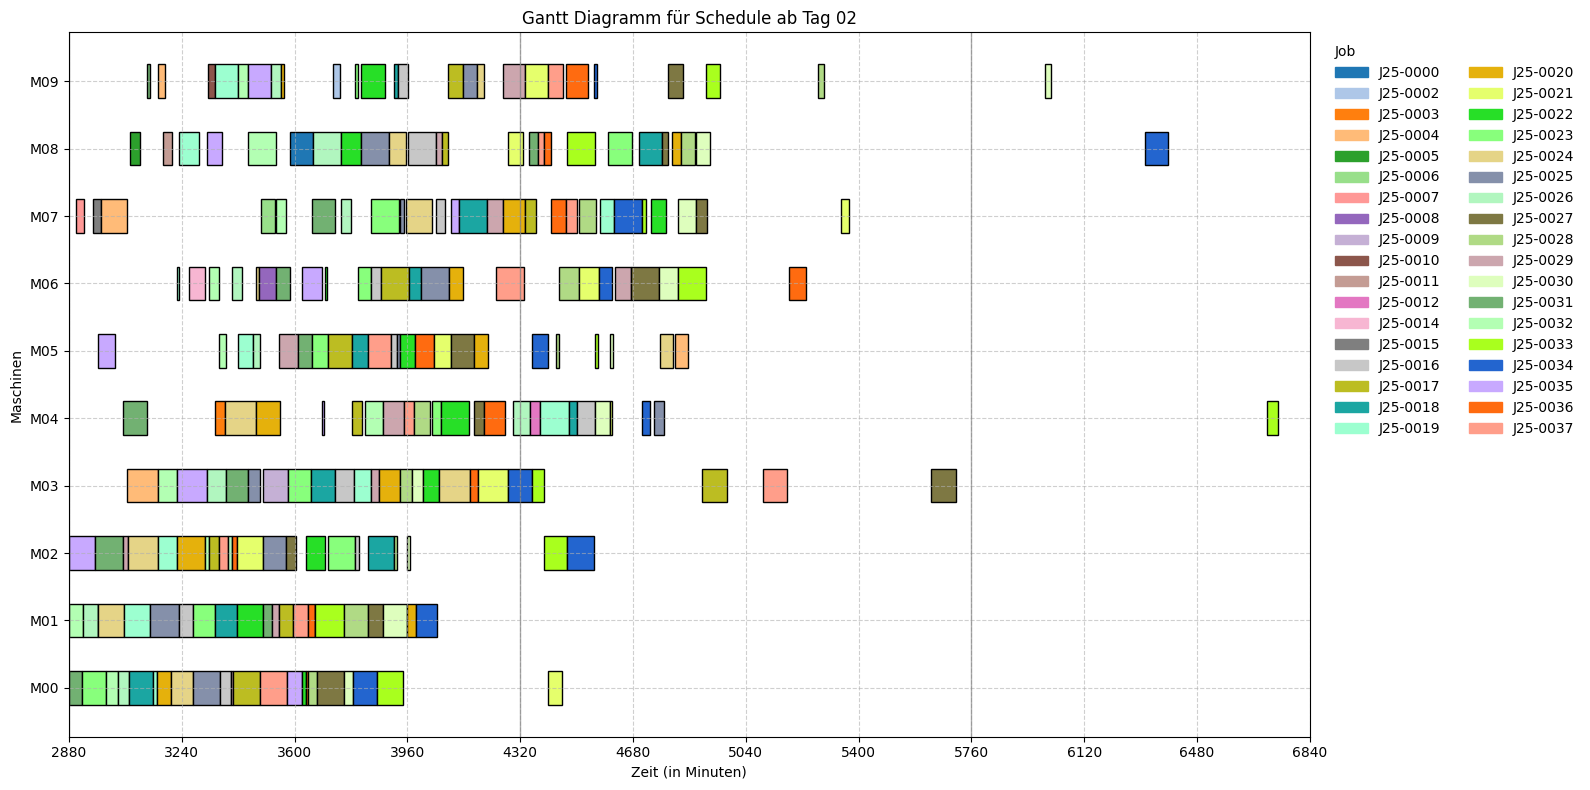

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

[Day 2 00:00:00] Job J25-0000, Operation 8 resumed with 2.00 min
[Day 2 00:00:00] Job J25-0031 started on M00
[Day 2 00:00:00] Job J25-0032 started on M01
[Day 2 00:00:00] Job J25-0035 started on M02
[Day 2 00:02:00] Job J25-0000 finished on M04 (after 02 minutes)
[Day 2 00:24:00] Job J25-0007 started on M07
[Day 2 00:48:00] Job J25-0031 finished on M00 (after 48 minutes)
[Day 2 00:48:00] Job J25-0023 started on M00
[Day 2 00:53:00] Job J25-0007 finished on M07 (after 29 minutes)
[Day 2 00:57:00] Job J25-0032 finished on M01 (after 57 minutes)
[Day 2 00:57:00] Job J25-0026 started on M01
[Day 2 01:14:00] Job J25-0035 finished on M02 (after 74 minutes)
[Day 2 01:16:00] Job J25-0015 started on M07
[Day 2 01:24:00] Job J25-0031 started on M

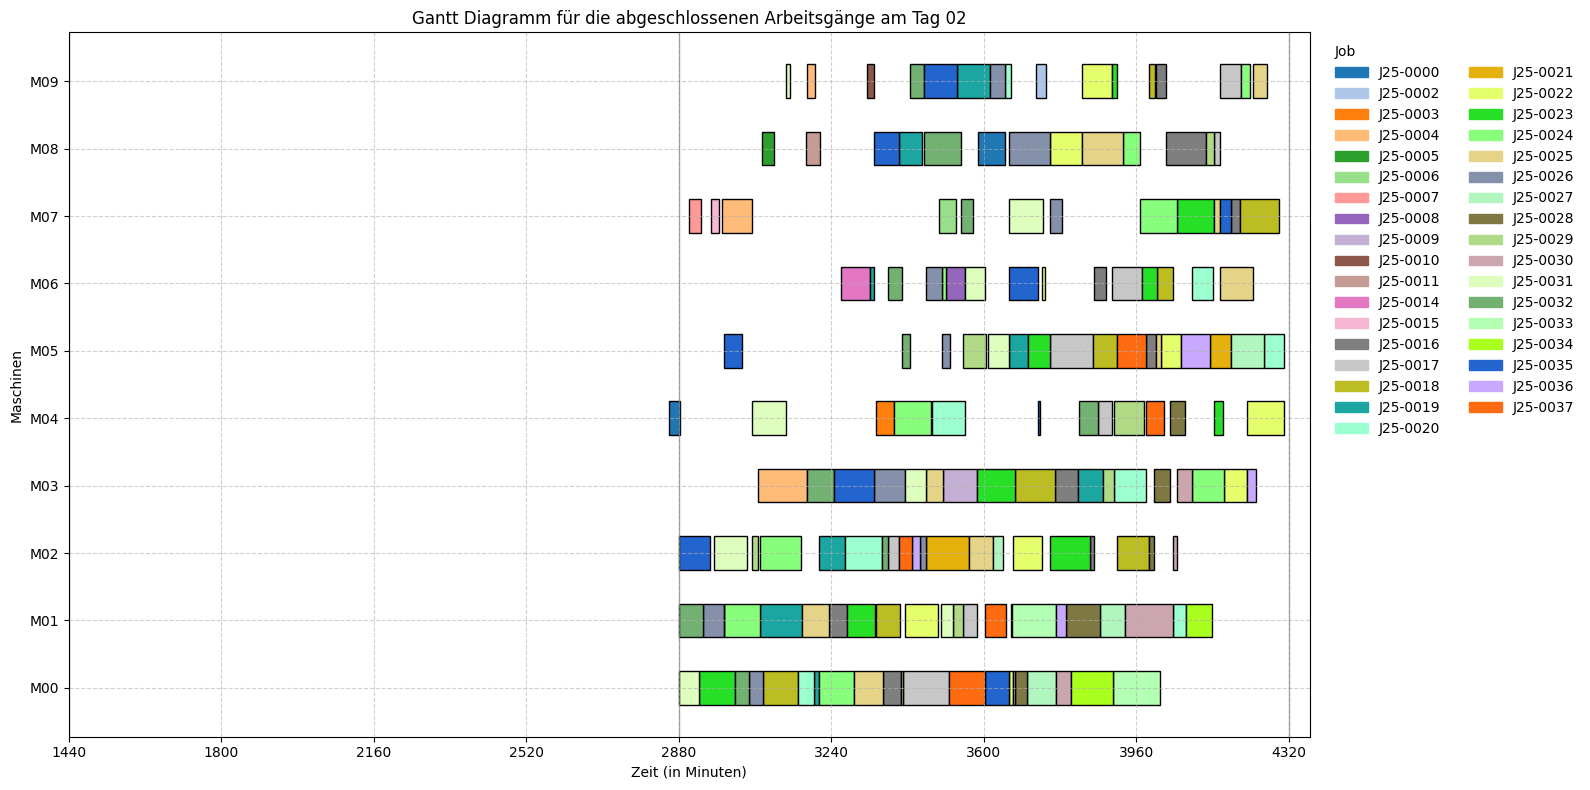

✅ 168 JobOperation-Einträge (Version 'CP_Lateness_v00_devpen', Status 'finished') wurden hinzugefügt oder aktualisiert.
✅ 4 JobOperation-Einträge (Version 'CP_Lateness_v00_devpen', Status 'active') wurden hinzugefügt oder aktualisiert.
✅ 14 Job(s) wurden auf 'nothing to schedule' gesetzt (Version 'CP_Lateness_v00_devpen').
Tag 03: [4320, 5760)


In [ ]:
first_start = 2
last_planning_start = 3

for day_numb in range(first_start, last_planning_start + 1):
    day_start = day_length * day_numb
    day_end = day_start + day_length
    print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

    # alle aktuelle "offenen" Jobs ("neue" und unerledigte Jobs)
    df_jobs_times_current = Job.get_dataframe(version=this_version, arrival_time_max=day_start, status="open")

    df_jssp_current = filter_current_jssp(
       df_jssp=df_jssp,
       df_jobs_times_current=df_jobs_times_current,
       exclusion_dataframes_list=[df_active, df_execution]
    )

    # --- Scheduling ---
    df_schedule = cp_late_reschedule.solve_jssp_by_tardiness_and_earliness_with_devpen(
        df_jssp = df_jssp_current, df_times = df_jobs_times_current,
        df_original_plan= df_schedule, df_active= df_active,
        reschedule_start = day_start, w_t = 5,
        r = 0.30,                                           # 30% Flowtime, 70% Abweichung
        msg=False, timeLimit=max_time, gapRel= 0.02
    )
    Schedule.add_schedule_from_dataframe(df_schedule, version=this_version, date=day_numb)

    show.plot_gantt(df_schedule, perspective="Machine", title=f"Gantt Diagramm für Schedule ab Tag {day_numb:02d}")
    check.all_in_one(df_schedule)

    # --- Simulation ---
    simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time = day_end)

    df_execution = simulation.get_finished_operations_df()
    show.plot_gantt(df_execution, perspective="Machine", title=f"Gantt Diagramm für die abgeschlossenen Arbeitsgänge am Tag {day_numb:02d}")

    df_active = simulation.get_active_operations_df()

    JobOperation.add_from_dataframe(df_execution, version=this_version, status="finished")

    if df_active is not None:
        JobOperation.add_from_dataframe(df_active, version=this_version, status="active")

    JobOperation.update_jobs_with_nothing_to_schedule(version=this_version)
